In [1]:
import numpy as np
import pandas as pd
from decimal import Decimal
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import sys
sys.getdefaultencoding()

'utf-8'

# Construção de um gráfico em papel milimetrado

## Criando conjuntos de dados de exemplo

In [2]:
dados1 = pd.DataFrame()
dados2 = pd.DataFrame()
dados3 = pd.DataFrame()

In [3]:
# fisexp 2 - densidade
dados1['x'] = np.array(range(260,314,6)) # massa em g
dados1['y'] = np.array([156, 162, 168, 174, 180, 186, 192, 198, 204])  # volume em ml
dados1['erro']  = np.array(np.ones(9))

# fisexp 2 - período do pêndulo
dados2['x'] = np.array([149.5, 137.5, 126.5, 113.5, 100.5]) # L em cm
dados2['y'] = np.array([2427, 2330, 2251, 2106, 1993]) # T em ms
dados2['erro']  = np.array([4, 4, 6, 7, 5])

# fisexp 2 - corda vibrante
dados3['x'] = np.array([334, 167, 111, 84, 67, 56, 48]) # comprimento de onda cm
dados3['y'] = np.array([12, 24, 36, 48, 59, 72, 83]) # frequencia Hz
dados3['erro']  = np.array(2*np.ones(7))

In [4]:
list(dados1['erro'])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

##### Função para retornar todos os parâmetros do cálculo de escala

In [5]:
def escala(h, v, dados):
    dados.fillna(0,inplace=True)    
    
    # cálculo do delta    
    delta_x = dados['x'].max()-dados['x'].min()
    dados_y_max  = (dados['y']+dados['erro']).max()
    dados_y_min = (dados['y']-dados['erro']).min()
    delta_y = dados_y_max - dados_y_min
    
    #cálculo da escala natural
    escala_nat_x = delta_x / h 
    escala_nat_y = delta_y / v 
    
    # função auxiliar para o cálculo da escala boa
    def fexp(number):
        (sign, digits, exponent) = Decimal(number).as_tuple()
        return len(digits) + exponent - 1

    def fman(number):
        return float(Decimal(number).scaleb(-fexp(number)).normalize())
    
    # cálculo da escala boa
    def escala_boa(num):
        exp = 10**fexp(num)
        man = fman(num)
        if man == 5 or man == 2 or man == 1:
            return num
        if man > 5:
            return 10*exp
        if man > 2:
            return 5*exp
        if man > 1:
            return 2*exp
        return exp
    
    escala_boa_x = escala_boa(escala_nat_x)
    escala_boa_y = escala_boa(escala_nat_y)
    
    delta_bom_x = escala_boa_x*h
    delta_bom_y = escala_boa_y*v
    
    # cálculo dos limites
    limite_x = [ round(dados['x'].min()-(delta_bom_x-delta_x)/2, 10),
    round(dados['x'].max()+(delta_bom_x-delta_x)/2, 10) ]
    limite_y = [ round(dados_y_min -(delta_bom_y-delta_y)/2, 10),
    round(dados_y_max +(delta_bom_y-delta_y)/2, 10) ]
    
    # cálculo dos limites bons
    def limite_bom(esc, num):
        esc_cm = 10*esc
        return round(num / esc_cm) * esc_cm
    v_limite_bom = np.vectorize(limite_bom)
    
    limite_bom_x = [ round(limite_bom(escala_boa_x, limite_x[1])-h*escala_boa_x, 10),
                     round(limite_bom(escala_boa_x, limite_x[1]), 10) ]
                   
    limite_bom_y = [ round(limite_bom(escala_boa_y, limite_y[1])-v*escala_boa_y, 10),
                     round(limite_bom(escala_boa_y, limite_y[1]), 10) ]
    
    # cálculo das divisões
    div_x = [ round(limite_bom_x[0] + escala_boa_x*10*i,10) for i in range(0,int(h/10+1)) ]
    div_y = [ round(limite_bom_y[0] + escala_boa_y*10*i,10) for i in range(0,int(v/10+1)) ]
    
    # conversão para mm
    dados_mm = pd.DataFrame()
    dados_mm['x_mm'] = v_limite_bom(0.05, (dados['x'] - div_x[0]) / escala_boa_x)
    dados_mm['y_mm'] = v_limite_bom(0.05, (dados['y'] - div_y[0]) / escala_boa_y)
    dados_mm['erro_mm']  = v_limite_bom(0.05, dados['erro'] / escala_boa_y) # tamanho da incerteza
    
    return (h, v,
            delta_x, delta_y,
            escala_nat_x, escala_nat_y,
            escala_boa_x, escala_boa_y,
            delta_bom_x, delta_bom_y,
            limite_x, limite_y,
            limite_bom_x, limite_bom_y,
            div_x, div_y,
            dados_mm
           )
    

In [6]:
(h, v,
 delta_x, delta_y,
 escala_nat_x, escala_nat_y,
 escala_boa_x, escala_boa_y,
 delta_bom_x, delta_bom_y,
 limite_x, limite_y,
 limite_bom_x, limite_bom_y,
 div_x, div_y,
 dados_mm) = escala(180, 280, dados1)

In [7]:
delta_y

50.0

## Salvando os resultados em um arquivo

In [8]:
arquivo = f'''{h} divisões na horizontal
{v} divisões na vertical
________________________________________________
Resultados eixo horizontal:

\u0394 = {round(delta_x,10)}

escala natural = {round(escala_nat_x,10)}

escala = {round(escala_boa_x,10)}

\u0394' = {round(delta_bom_x,10)}

limites = {limite_x}

limites corrigidos = {limite_bom_x}

escala de leitura 
{div_x}

________________________________________________
Resultados eixo vertical:

\u0394 = {round(delta_y,10)}

escala natural = {round(escala_nat_y,10)}

escala = {round(escala_boa_y,10)}

\u0394' = {round(delta_bom_y,10)}

limites = {limite_y}

limites corrigidos = {limite_bom_y}

escala de leitura 
{div_y}

________________________________________________
Dados em divisões 
{dados_mm} 

-----------------------------------------------------------------------------
MP-resuldados
Dos dados aos resultados. Um pouco de física, matemática, negócios e finanças.
mp.resuldados@gmail.com
'''
print(arquivo)


180 divisões na horizontal
280 divisões na vertical
________________________________________________
Resultados eixo horizontal:

Δ = 48

escala natural = 0.2666666667

escala = 0.5

Δ' = 90.0

limites = [239.0, 329.0]

limites corrigidos = [240.0, 330.0]

escala de leitura 
[240.0, 245.0, 250.0, 255.0, 260.0, 265.0, 270.0, 275.0, 280.0, 285.0, 290.0, 295.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0]

________________________________________________
Resultados eixo vertical:

Δ = 50.0

escala natural = 0.1785714286

escala = 0.2

Δ' = 56.0

limites = [152.0, 208.0]

limites corrigidos = [152.0, 208.0]

escala de leitura 
[152.0, 154.0, 156.0, 158.0, 160.0, 162.0, 164.0, 166.0, 168.0, 170.0, 172.0, 174.0, 176.0, 178.0, 180.0, 182.0, 184.0, 186.0, 188.0, 190.0, 192.0, 194.0, 196.0, 198.0, 200.0, 202.0, 204.0, 206.0, 208.0]

________________________________________________
Dados em divisões 
    x_mm   y_mm  erro_mm
0   40.0   20.0      5.0
1   52.0   50.0      5.0
2   64.0   80.0 

In [9]:
import codecs

with codecs.open('./resultados/densidade.txt', 'w', encoding='utf-8') as file:
    file.write(arquivo)

## Gráfico

In [8]:
def plot(h, v, dados, xlabel, ylabel):
# cálculo da escala
    (h, v,
     delta_x, delta_y,
     escala_nat_x, escala_nat_y,
     escala_boa_x, escala_boa_y,
     delta_bom_x, delta_bom_y,
     limite_x, limite_y,
     limite_bom_x, limite_bom_y,
     div_x, div_y,
     dados_mm) = escala(h, v, dados)
    
# proporcionalização
    ratio =(v/(np.array(div_y).max()-np.array(div_y).min()))/(h/(np.array(div_x).max()-np.array(div_x).min()))

    fig, ax = plt.subplots(figsize=(8.3, 11.7)) # tamanho A4

    ax.set_aspect(ratio)

    ax.set_title('Papel milimetrado')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(div_x[0],div_x[-1])
    ax.set_ylim(div_y[0],div_y[-1])

# grid lines
    ax.grid(which = "major")
    ax.grid(which = "minor", alpha = 0.2)
    ax.set_axisbelow(True)

    ax.tick_params(which = "minor", bottom = False, left = False)

#  major grid do eixo horizontal
    #ax.xaxis.set_major_locator(FixedLocator(div_x))

#  major grid do eixo vertical
    #ax.yaxis.set_major_locator(FixedLocator(div_y))

#  minor grid dividindo o major grid em 10
    #ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    #ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# plot
    ax.errorbar(
        dados['x'],
        dados['y'],
        yerr = dados['erro'],
        marker='.',
        linestyle='none',
        color='green',
        label='dados experimentais',
        )
    #fig.savefig(f'./imagens/{ylabel} x {xlabel}.png', format='png')

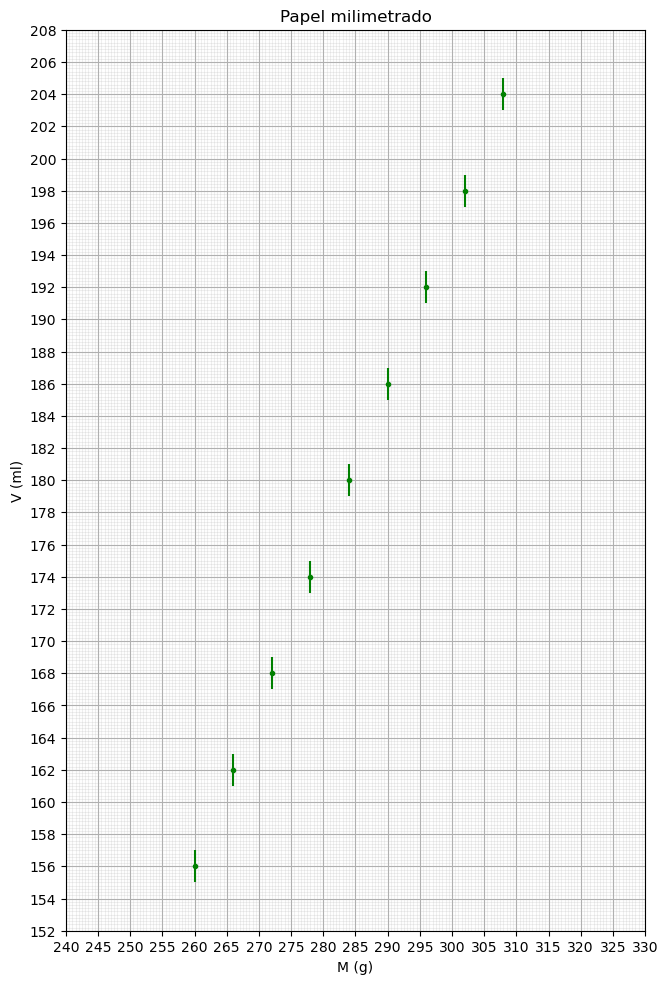

In [9]:
plot(180, 280, dados1, 'M (g)', 'V (ml)')

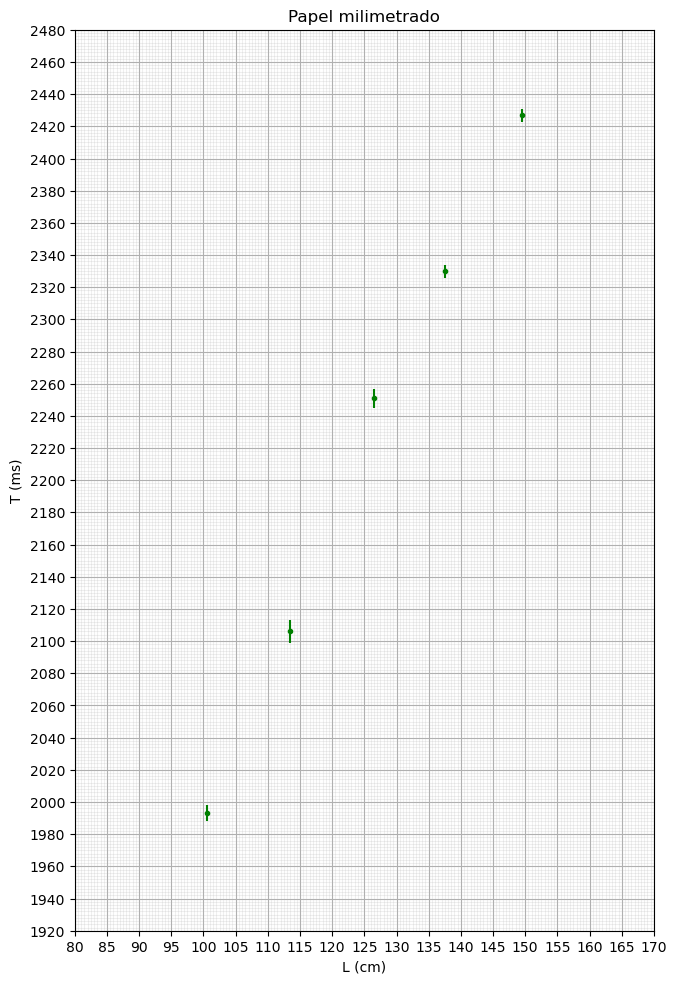

In [10]:
plot(180, 280, dados2, 'L (cm)', 'T (ms)')

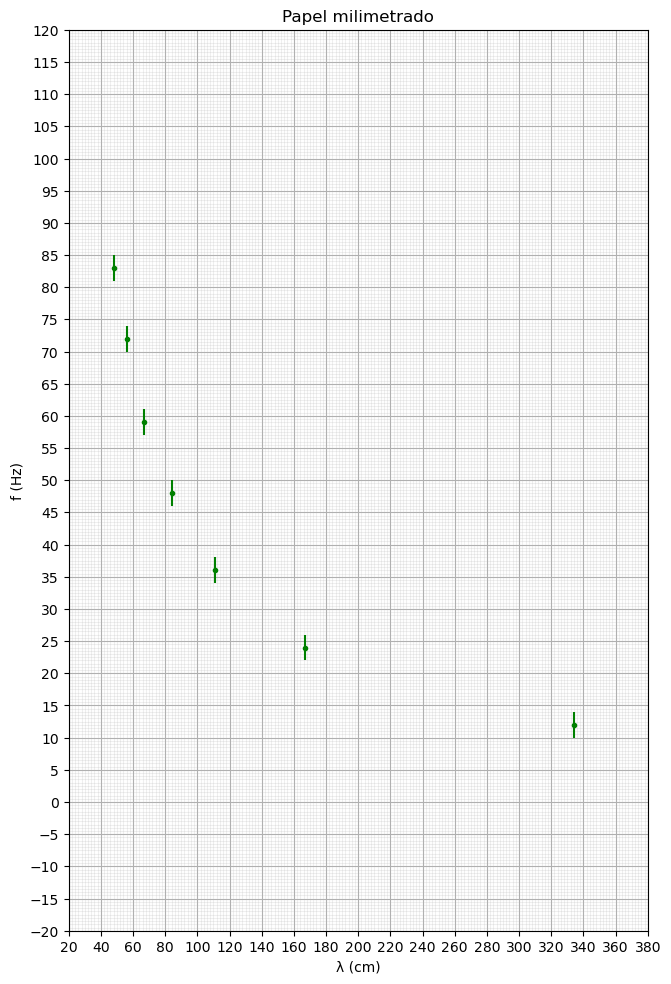

In [11]:
plot(180, 280, dados3, '\u03BB (cm)', 'f (Hz)')

### Construção do paralelogramo para gráficos lineares

In [12]:
# funções auxiliares

from math import log10, floor

def round_it(x, sig):
    return round(x, sig - int(floor(log10(abs(x)))) - 1)

def fexp(number):
        (sign, digits, exponent) = Decimal(number).as_tuple()
        return len(digits) + exponent - 1

def fman(number):
    return float(Decimal(number).scaleb(-fexp(number)).normalize())

## Função para o método do paralelogramo

In [13]:
# aumentando a barra de erro para o exemplo ser mais didático
dados1['erro']  = 0.02*dados1['x']

In [14]:
def paralelogramo(dados):
    x = dados['x']
    y = dados['y']
    y_err = dados['erro']
    
    modelo = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
    a = modelo.coef_[0]
    y_reta = modelo.predict(np.array(x).reshape(-1, 1))
    
    idx_max = (y+y_err-y_reta).idxmax( )
    idx_min = (y-y_err-y_reta).idxmin( )

    b1 = ( (y+y_err)[idx_max]- a*x[idx_max] )
    b2 = ( (y-y_err)[idx_min]- a*x[idx_min] )
    
    a_max = ( (a*x.max() + b1)-(a*x.min() + b2) )/ (x.max()-x.min())
    a_min = ( (a*x.max() + b2)-(a*x.min() + b1) )/ (x.max()-x.min())
    
    a_medio = (a_max + a_min)/2
    erro_a = round_it((a_max - a_min)/2,1)

    b_max = (a*x.max()+b2) - a_min*x.max()
    b_min = (a*x.max()+b1) - a_max*x.max()
    
    b_medio = (b_max + b_min)/2
    erro_b = round_it((b_max - b_min)/2,1)
    
    return a_max, a_min, b_max, b_min, a_medio, erro_a, b_medio, erro_b, b1, b2

paralelogramo(dados1)

(1.2566666666666666,
 0.7433333333333335,
 -31.10666666666671,
 -176.8933333333333,
 1.0,
 0.3,
 -104.0,
 70.0,
 -97.84,
 -110.16)

In [15]:
paralelogramo(dados1)

(1.2566666666666666,
 0.7433333333333335,
 -31.10666666666671,
 -176.8933333333333,
 1.0,
 0.3,
 -104.0,
 70.0,
 -97.84,
 -110.16)

In [16]:
a_max, a_min, b_max, b_min, a_medio, erro_a, b_medio, erro_b, b1, b2 = paralelogramo(dados1)

In [17]:
arq_paralelogramo = f'''_______________________________________________________
Resultados dos coeficientes do método do paralelogramo:

reta com maior coeficiente angular:
a_max = {a_max}
b_min = {b_min}

reta com menor coeficiente angular:
a_min = {a_min}
b_max = {b_max}
_______________________________________________________
Resultados dos coeficientes da reta y = a x + b:

a = {a_medio}
erro de a = {erro_a}

b = {b_medio}
erro de b = {erro_b}

-----------------------------------------------------------------------------
MP-resuldados
Dos dados aos resultados. Um pouco de física, matemática, negócios e finanças.
mp.resuldados@gmail.com
  
'''
print(arq_paralelogramo)


_______________________________________________________
Resultados dos coeficientes do método do paralelogramo:

reta com maior coeficiente angular:
a_max = 1.2566666666666666
b_min = -176.8933333333333

reta com menor coeficiente angular:
a_min = 0.7433333333333335
b_max = -31.10666666666671
_______________________________________________________
Resultados dos coeficientes da reta y = a x + b:

a = 1.0
erro de a = 0.3

b = -104.0
erro de b = 70.0

  



In [18]:
#import codecs

#with codecs.open('./resultados/densidade_paralelogramo.txt', 'w', encoding='utf-8') as file:
#    file.write(arq_paralelogramo)

# Plot do paralelogramo

In [36]:
def plot(h, v, dados, xlabel, ylabel):
# cálculo da escala
    (h, v,
     delta_x, delta_y,
     escala_nat_x, escala_nat_y,
     escala_boa_x, escala_boa_y,
     delta_bom_x, delta_bom_y,
     limite_x, limite_y,
     limite_bom_x, limite_bom_y,
     div_x, div_y,
     dados_mm) = escala(h, v, dados)
    
# cálculo do paralelogramo
    a_max, a_min, b_max, b_min, a_medio, erro_a, b_medio, erro_b, b1, b2 = paralelogramo(dados)

# proporcionalização
    ratio =(v/(np.array(div_y).max()-np.array(div_y).min()))/(h/(np.array(div_x).max()-np.array(div_x).min()))

    fig, ax = plt.subplots(figsize=(8.3, 11.7)) # tamanho A4

    ax.set_aspect(ratio)

    ax.set_title('Papel milimetrado')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_xlim(div_x[0],div_x[-1])
    ax.set_ylim(div_y[0],div_y[-1])

# grid lines
    ax.grid(which = "major")
    ax.grid(which = "minor", alpha = 0.2)
    ax.set_axisbelow(True)

    ax.tick_params(which = "minor", bottom = False, left = False)
    
    for label in ax.get_xticklabels(which='major'):
        label.set(rotation=90)

#  major grid do eixo horizontal
    ax.xaxis.set_major_locator(FixedLocator(div_x))

#  major grid do eixo vertical
    ax.yaxis.set_major_locator(FixedLocator(div_y))

#  minor grid dividindo o major grid em 10
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    ax.yaxis.set_minor_locator(AutoMinorLocator(10))

# plot
    x = dados['x']
    y = dados['y']
    y_err = dados['erro']
    
    ax.errorbar(
        x,
        y,
        yerr = y_err,
        marker='.',
        linestyle='none',
        color='green',
        label='dados experimentais',
        )
# paralelogramo
    ax.plot(
        x,
        a_medio*x+b_medio,
        linestyle='-',
        color='red',
        label='ajuste linear',
    )
    ax.plot(
        x,
        a_medio*x+b1,
        linestyle='--',
        color='orange',
        label='método do paralelogramo',
    )
    ax.plot(
        x,
        a_medio*x+b2,
        linestyle='--',
        color='orange',

    )
    ax.plot(
        x,
        a_max*x+b_min,
        linestyle=':',
        color='orange',
    )
    ax.plot(
        x,
        a_min*x+b_max,
        linestyle=':',
        color='orange',
    )

    ax.legend(loc='upper left', ncols=1)
    #fig.savefig(f'./imagens/paralelogramo-{ylabel} x {xlabel}.png', format='png')

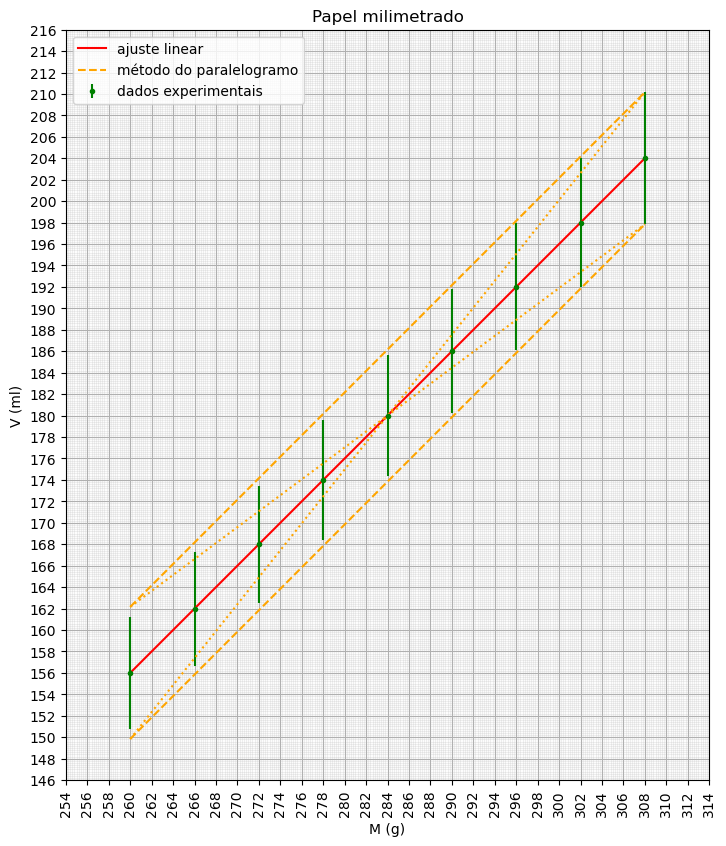

In [37]:
plot(300, 350, dados1,  'M (g)', 'V (ml)')